<a href="https://colab.research.google.com/github/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/blob/main/finalprojectcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Concatenate, Dense, TimeDistributed, LSTM, Embedding, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import string
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split

In [11]:
import os
import re
import unicodedata
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Layer
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
import numpy as np
import pandas as pd

## loading data

In [3]:
data ='https://raw.githubusercontent.com/baddepudisaideepak/Comparative-analysis-of-Neural-Deep-learning-approaches-for-NEWS-text-Summarization/refs/heads/main/news_summary.csv'

In [4]:
data = pd.read_csv(data, encoding='latin-1')

In [5]:
data.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [6]:
# Drop columns that are not needed
data = data[['headlines', 'text']]

# Display the first few rows to ensure the DataFrame has only the required columns
data.head()

,headlines,text
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...


In [7]:
data.shape

(4514, 2)

In [8]:
def print_head(limit=5):
    # Ensure the limit does not exceed the number of rows in the dataset
    limit = min(limit, len(data))

    for idx in range(limit):
        print(f'TITLE: {data["headlines"][idx]}\nTEXT: {data["text"][idx]}\n')

# Call the function to print the first 5 headline-text pairs
print_head()


TITLE: Daman & Diu revokes mandatory Rakshabandhan in offices order
TEXT: The Administration of Union Territory Daman and Diu has revoked its order that made it compulsory for women to tie rakhis to their male colleagues on the occasion of Rakshabandhan on August 7. The administration was forced to withdraw the decision within 24 hours of issuing the circular after it received flak from employees and was slammed on social media.

TITLE: Malaika slams user who trolled her for 'divorcing rich man' 
TEXT: Malaika Arora slammed an Instagram user who trolled her for "divorcing a rich man" and "having fun with the alimony". "Her life now is all about wearing short clothes, going to gym or salon, enjoying vacation[s]," the user commented. Malaika responded, "You certainly got to get your damn facts right before spewing sh*t on me...when you know nothing about me."

TITLE: 'Virgin' now corrected to 'Unmarried' in IGIMS' form
TEXT: The Indira Gandhi Institute of Medical Sciences (IGIMS) in Patn

## preprocessing dataset

In [9]:
def preprocess(text):
    """Preprocess the given text."""

    # Encode to ascii
    text = ''.join(
        c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn'
    )

    # To lowercase
    text = text.lower()

    text = re.sub("(\\t)", ' ', text)  #remove escape charecters
    text = re.sub("(\\r)", ' ', text)
    text = re.sub("(\\n)", ' ', text)
    text = re.sub("(__+)", ' ', text)   #remove _ if it occors more than one time consecutively
    text = re.sub("(--+)", ' ', text)   #remove - if it occors more than one time consecutively
    text = re.sub("(~~+)", ' ', text)   #remove ~ if it occors more than one time consecutively
    text = re.sub("(\+\++)", ' ', text)   #remove + if it occors more than one time consecutively
    text = re.sub("(\.\.+)", ' ', text)   #remove . if it occors more than one time consecutively
    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', text) #remove <>()|&©ø"',;?~*!
    text = re.sub("(mailto:)", ' ', text)  #remove mailto:
    text = re.sub(r"(\\x9\d)", ' ', text)  #remove \x9* in text
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', text)  #replace INC nums to INC_NUM
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', text)  #replace CM# and CHG# to CM_NUM
    text = re.sub("(\.\s+)", ' ', text)  #remove full stop at end of words(not between)
    text = re.sub("(\-\s+)", ' ', text)  #remove - at end of words(not between)
    text = re.sub("(\:\s+)", ' ', text)  #remove : at end of words(not between)
    text = re.sub("(\s+.\s+)", ' ', text)  #remove any single charecters hanging between 2 spaces

    #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', text)
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, text)
    except:
        pass #there might be emails with no url in them

    text = re.sub("(\s+)",' ',text) #remove multiple spaces
    text = re.sub("(\s+.\s+)", ' ', text) #remove any single charecters hanging between 2 spaces
    return text

In [10]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=data)

https://docs.google.com/spreadsheets/d/1Ra_bwz3NII_sev1vmVo84cn3lD9yYzegJA2vYlUwBcg#gid=0


In [12]:
# Display summary statistics of the dataset
data.describe(include='all')


,headlines,text
count,4514,4514
unique,4514,4514
top,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...
freq,1,1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  4514 non-null   object
 1   text       4514 non-null   object
dtypes: object(2)
memory usage: 70.7+ KB


In [14]:
%%time
data['headlines'] = data['headlines'].apply(preprocess)
data['text'] = data['text'].apply(preprocess)

CPU times: user 994 ms, sys: 3.8 ms, total: 998 ms
Wall time: 1.01 s


### visualization

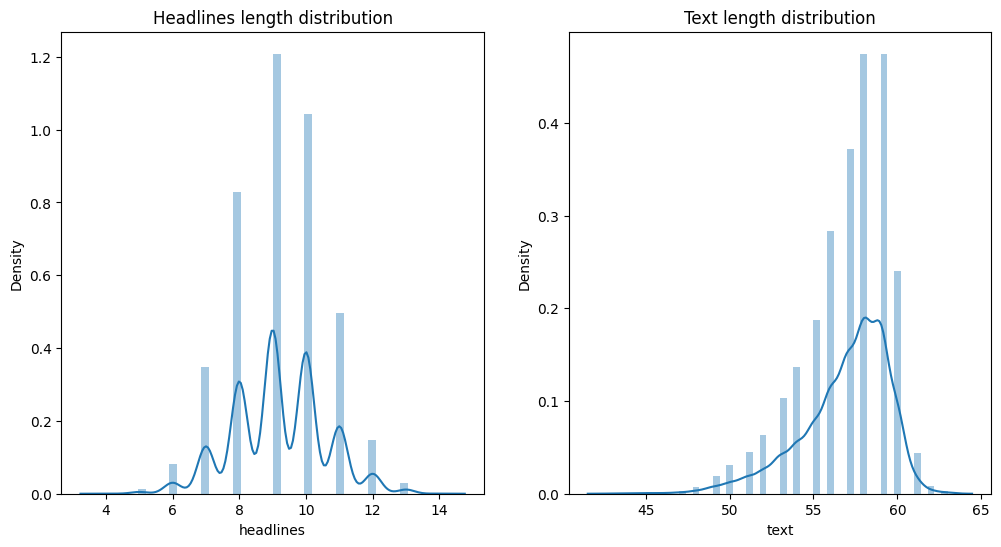

In [16]:
text_lens = data['text'].str.split().apply(len)
headline_lens = data['headlines'].str.split().apply(len)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.distplot(headline_lens)
plt.title('Headlines length distribution')

plt.subplot(1, 2, 2)
sns.distplot(text_lens)
plt.title('Text length distribution')

plt.show()

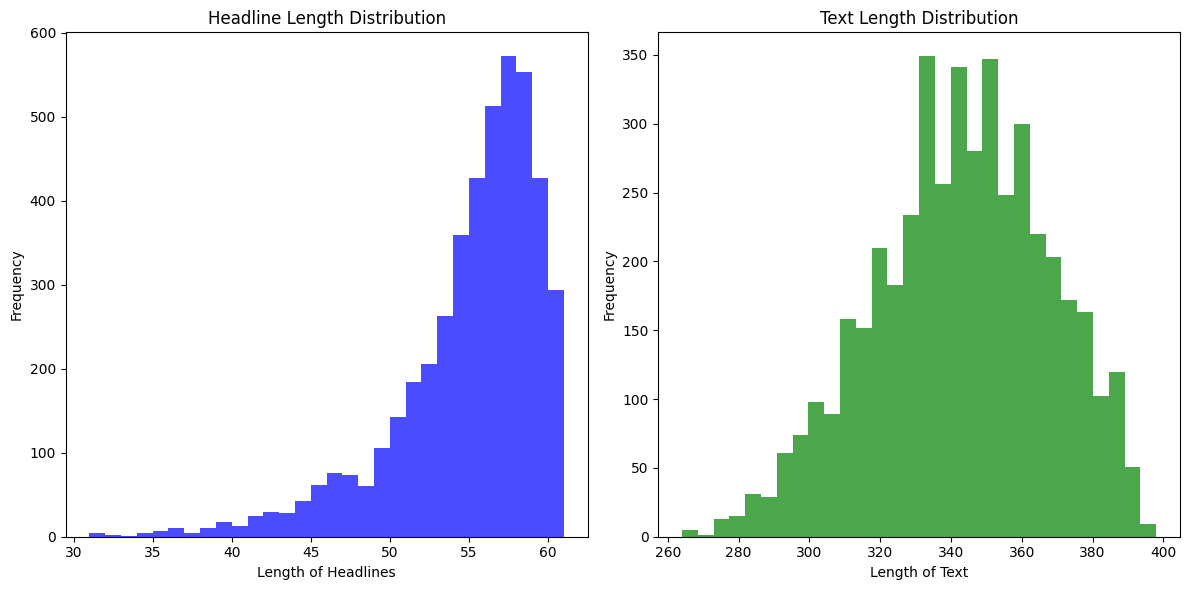

In [15]:
import matplotlib.pyplot as plt

# Calculate the length of each headline and text
data['headline_length'] = data['headlines'].apply(len)
data['text_length'] = data['text'].apply(len)

# Plotting the distribution of headline and text lengths
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data['headline_length'], bins=30, color='blue', alpha=0.7)
plt.title('Headline Length Distribution')
plt.xlabel('Length of Headlines')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data['text_length'], bins=30, color='green', alpha=0.7)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


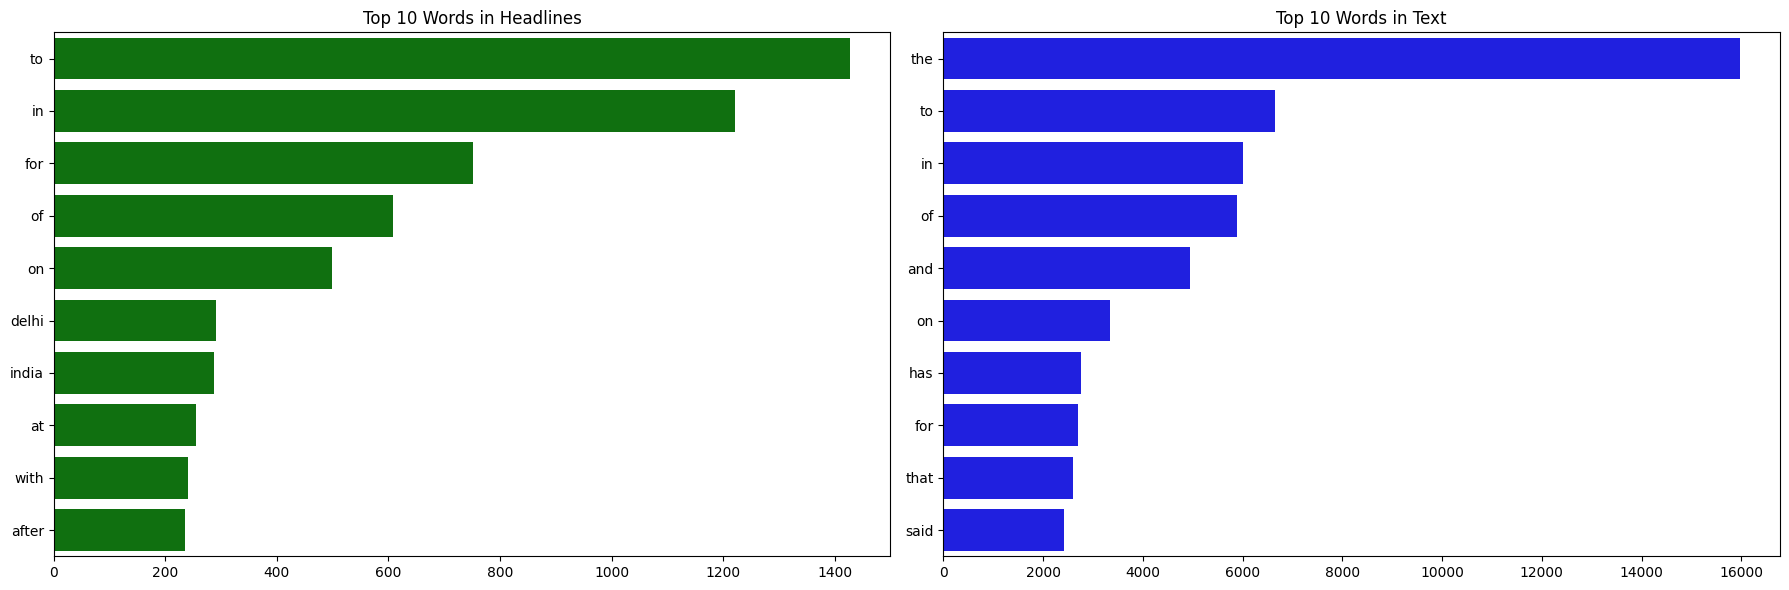

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Function to count words
def word_counter(text_series):
    count = Counter()
    for text in text_series:
        words = text.split()
        count.update(words)
    return count

# Count words in headlines and text
headline_words = word_counter(data['headlines'])
text_words = word_counter(data['text'])

# Most common words in headlines
common_headline_words = dict(headline_words.most_common(10))
common_text_words = dict(text_words.most_common(10))

# Plotting
plt.figure(figsize=(18, 6))

# For headlines
plt.subplot(1, 2, 1)
sns.barplot(x=list(common_headline_words.values()), y=list(common_headline_words.keys()), color='green')  # Specified color directly
plt.title('Top 10 Words in Headlines')

# For text
plt.subplot(1, 2, 2)
sns.barplot(x=list(common_text_words.values()), y=list(common_text_words.keys()), color='blue')  # Specified color directly
plt.title('Top 10 Words in Text')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [18]:
# Checking mean lengths
print(f'Mean headline length: {headline_lens.mean()}')
print(f'Mean text length: {text_lens.mean()}')

Mean headline length: 9.185866194062916
Mean text length: 56.91470979175897


In [22]:
# Check how much % of headlines have 0-15 words
print(f"Headlines having length in range [0, 15]: {len(headline_lens[headline_lens <= 15])/len(headline_lens)}")

# Check how much % of text have 0-62 words
print(f"Text having length in range [0, 62]: {len(text_lens[text_lens <= 62])/len(text_lens)}")

Headlines having length in range [0, 15]: 1.0
Text having length in range [0, 62]: 0.9986708019494904


In [23]:
MAX_TEXT_SEQ_LEN = 62
MAX_HEADLINE_SEQ_LEN = 15

In [24]:
START_TOKEN = '<start> '
END_TOKEN = ' <end>'

In [25]:
data['headlines_input'] = START_TOKEN + data['headlines']
data['headlines_output'] = data['headlines'] + END_TOKEN

In [26]:
data = data.drop(['headlines'], axis=1)
data.head(2)

,text,headline_length,text_length,headlines_input,headlines_output
0,the administration of union territory daman an...,58,355,<start> daman diu revokes mandatory rakshaband...,daman diu revokes mandatory rakshabandhan in o...
1,malaika arora slammed an instagram user who tr...,58,338,<start> malaika slams user who trolled her for...,malaika slams user who trolled her for divorci...


In [ ]:
# Parameters
max_vocab_size = 10000
max_sequence_length = 100
embedding_dim = 100

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(pd.concat([data['text'], data['headlines']]))

# Convert texts to sequences of integers
data['text_seq'] = tokenizer.texts_to_sequences(data['text'])
data['headlines_seq'] = tokenizer.texts_to_sequences(data['headlines'])

# Pad the sequences
data['text_seq'] = pad_sequences(data['text_seq'], maxlen=max_sequence_length, padding='post')
data['headlines_seq'] = pad_sequences(data['headlines_seq'], maxlen=max_sequence_length, padding='post')

# Define the embedding layer
embedding_layer = Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Split the data into training and testing sets
X = data['text_seq']
y = data['headlines_seq']
X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y.tolist(), test_size=0.2, random_state=42)

# Parameters
batch_size = 64
epochs = 50
latent_dim = 256  # Latent dimensionality of the encoding space.

# Encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(max_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

# Convert to numpy arrays for training
X_train = np.array(X_train)
y_train = np.expand_dims(np.array(y_train), -1)  # Expanding dims for labels to fit sparse_categorical_crossentropy
X_test = np.array(X_test)
y_test = np.expand_dims(np.array(y_test), -1)

# Train the model
model.fit([X_train, y_train[:, :-1]], y_train[:, 1:], batch_size=batch_size, epochs=epochs, validation_data=([X_test, y_test[:, :-1]], y_test[:, 1:]))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 100)      │      1,000,000 │ input_layer_2[0][0],   │
│                           │                        │                │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 256), (None,   │        365,568 │ embedding[2][0]        │
│                           │ 256), (None, 256)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        365,568 │ embedding[3][0],       │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 10000)    │      2,570,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,301,136 (16.41 MB)

 Trainable params: 4,301,136 (16.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("functional_1_1/Cast:0", shape=(None,), dtype=float32). Expected shape (None, None), but input has incompatible shape (None,)[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(None,), dtype=int64)', 'tf.Tensor(shape=(None, 0), dtype=int64)')
  • training=True
  • mask=('None', 'None')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Model parameters
latent_dim = 256  # Latent dimensionality of the encoding space.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,))
encoder_embedding = embedding_layer(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_embedding = embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(max_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Assuming your `Y_train` and `Y_test` are already shaped as (num_samples, sequence_length, 1)
# Create decoder inputs by shifting the target sequences
decoder_input_train = np.hstack([np.zeros((Y_train.shape[0], 1, 1)), Y_train[:, :-1, :]])
decoder_input_test = np.hstack([np.zeros((Y_test.shape[0], 1, 1)), Y_test[:, :-1, :]])

# The targets for the decoder need to be offset by one timestep
decoder_target_train = Y_train[:, 1:, :]
decoder_target_test = Y_test[:, 1:, :]


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

In [ ]:
# Assuming you've defined a model compatible with these inputs
epochs = 30
batch_size = 64

# Prepare decoder inputs and targets by shifting Y sequences for correct sequence prediction training
decoder_input_train = np.hstack([np.zeros((Y_train.shape[0], 1, 1)), Y_train[:, :-1]])
decoder_input_test = np.hstack([np.zeros((Y_test.shape[0], 1, 1)), Y_test[:, :-1]])

# Fit the model
history = model.fit(
    [X_train, decoder_input_train],  # Encoder input and Decoder input
    Y_train[:, 1:],  # Decoder target (shifted by 1)
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([X_test, decoder_input_test], Y_test[:, 1:]),
    verbose=1
)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)